In [1]:
import numpy as np
import pandas as pd
from path import Path
from xgboost import XGBRegressor
%matplotlib inline
from sklearn import metrics

In [2]:
def read_csv(csv_name):
    #Read TSLA.csv contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volumes
    file_path = Path(csv_name)
    df = pd.read_csv(file_path)
    #Drop null values
    df.dropna(inplace=True)
    
    return df

In [3]:
def adjusted_df(df):
    #Dataframe with Adj close, ts_polarity, twitter_volume
    df = df[["Close", "compound", "Count"]]
    
    #pct change based on Adj close value
    df["Pct_change"] = df["Close"].pct_change()

    #Drop null values 
    df.dropna(inplace=True)
    df.head()
    
    return df

Creating the Features X and Target y Data

The first step towards preparing the data was to create the input features X and the target vector y. We used the window_data() function to create these vectors.

This function chunks the data up with a rolling window of Xt - window to predict Xt.

The function returns two numpy arrays:

X: The input features vectors.

y: The target vector.

The function has the following parameters:

df: The original DataFrame with the time series data.

window: The window size in days of previous closing prices that will be used for the prediction.

feature_col_number: The column number from the original DataFrame where the features are located.

target_col_number: The column number from the original DataFrame where the target is located.

In [4]:
#Creation of vectors X and Y 
#X = input features / Y = target vector

def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    #Create empty lists "X_close", "X_polarity",  "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    
    for i in range(len(df) - window):
        
        #Get close, ts_polarity, tw_vol and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        compound = df.iloc[i:(i + window), feature_col_number2]
        count = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        #Append values in the lists
        X_close.append(close)
        X_polarity.append(compound)
        X_volume.append(count)
        y.append(target)
        
    return np.hstack((X_close, X_polarity, X_volume)), np.array(y).reshape(-1, 1)

In [5]:
#Predict closing prices using a 3 day window of previous closing prices
window_size1 = 3

#Column index 0 is the "Close" column
#Column index 1 is the "ts_polarity"
#Column index 2 is the "twitter_volume" column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0 
#X, y = window_data(df, window_size1, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)


In [6]:
def split_data(X, y):
    #Use 70% of the data for training and 30% for testing
    X_split = int(0.7 * len(X))
    y_split = int(0.7 * len(y))

    #Set X_train, X_test, y_train, t_test
    X_train = X[:X_split]
    X_test = X[X_split:]
    y_train = y[:y_split]
    y_test = y[y_split:]
    
    return X_train, X_test, y_train, y_test

Scaling Data with MinMaxScaler

We will use the MinMaxScaler from sklearn to scale all values between 0 and 1. Note that we scale both features and target sets.

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
def scale_data(X_train, y_train, X_test, y_test):
    #Use MinMaxScaler to scale data between 0 and 1
    x_train_scaler = MinMaxScaler()
    x_test_scaler = MinMaxScaler()
    y_train_scaler = MinMaxScaler()
    y_test_scaler = MinMaxScaler()

    #Fit the scaler for the Training data
    x_train_scaler.fit(X_train)
    y_train_scaler.fit(y_train)

    #Scale the training data
    X_train = x_train_scaler.transform(X_train)
    y_train = y_train_scaler.transform(y_train)

    #Fit the scaler for the Test data 
    x_test_scaler.fit(X_test)
    y_test_scaler.fit(y_test)

    #Scale the test data
    X_test = x_test_scaler.transform(X_test)
    y_test = y_test_scaler.transform(y_test)
    
    return X_train, y_train, X_test, y_test, y_test_scaler

In [9]:
def create_instance():    
    #Create the XG Boost regressor instance
    model = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
    
    return model

In [10]:
def train_model(model, X_train, y_train):   
    #Fit the model
    model.fit(X_train, y_train.ravel())
    
    return model

Model Performance

In this section, we will evaluate the model using the test data.

We will:

1. Evaluate the model using the X_test and y_test data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values.
4. Plot the Real vs predicted values as a line chart

In [11]:
def make_pred(model, X_test)  :  
    #Make predictions 
    predicted = model.predict(X_test)
    
    return predicted

In [12]:
def calc_evaluation(y_test, predicted):
    #Evaluation of model
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r_squared = metrics.r2_score(y_test, predicted)
    print("Root Mean Squared Error: ", rmse)
    print("R-squared: ", r_squared)
    
    return rmse, r_squared

In [13]:
def show_pred(y_test, y_test_scaler, predicted, df):    
    #Recover the original prices instead of the scaled version
    predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
    real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    #Create a dataframe of Real and Predicted values
    stocks = pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel(),
    }, index = df.index[-len(real_prices): ])
    stocks.head()
    
    return stocks

In [14]:
def plot_prediction(stocks, name):
    #Plot the real vs predicted values as a line chart
    import matplotlib.pyplot as plt
    import pandas as pd

    # gca stands for 'get current axis'
    ax = plt.gca()

    stocks.plot(kind='line',y='Real',ax=ax, title=name)
    stocks.plot(kind='line',y='Predicted', color='red', ax=ax)

    plt.show()

In [15]:
aapl_df = read_csv("../input_data/aapl_input.csv")
btc_df = read_csv("../input_data/btc_input.csv")
jnj_df = read_csv("../input_data/jnj_input.csv")
msft_df = read_csv("../input_data/msft_input.csv")
nflx_df = read_csv("../input_data/nflx_input.csv")
pfe_df = read_csv("../input_data/pfe_input.csv")
tsla_df = read_csv("../input_data/tsla_input.csv")

In [16]:
aapl_df = adjusted_df(aapl_df)
btc_df = adjusted_df(btc_df)
jnj_df = adjusted_df(jnj_df)
msft_df = adjusted_df(msft_df)
nflx_df = adjusted_df(nflx_df)
pfe_df = adjusted_df(pfe_df)
tsla_df = adjusted_df(tsla_df)

/Users/namirsacic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/namirsacic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [17]:
X_aapl, y_aapl = window_data(aapl_df, window_size1, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)
X_btc, y_btc = window_data(btc_df, window_size1, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)
X_jnj, y_jnj = window_data(jnj_df, window_size1, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)
X_msft, y_msft = window_data(msft_df, window_size1, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)
X_nflx, y_nflx = window_data(nflx_df, window_size1, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)
X_pfe, y_pfe = window_data(pfe_df, window_size1, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)
X_tsla, y_tsla = window_data(tsla_df, window_size1, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [18]:
X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = split_data(X_aapl, y_aapl)
X_train_btc, X_test_btc, y_train_btc, y_test_btc = split_data(X_btc, y_btc)
X_train_jnj, X_test_jnj, y_train_jnj, y_test_jnj = split_data(X_jnj, y_jnj)
X_train_msft, X_test_msft, y_train_msft, y_test_msft = split_data(X_msft, y_msft)
X_train_nflx, X_test_nflx, y_train_nflx, y_test_nflx = split_data(X_nflx, y_nflx)
X_train_pfe, X_test_pfe, y_train_pfe, y_test_pfe = split_data(X_pfe, y_pfe)
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = split_data(X_tsla, y_tsla)

In [19]:
X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl, y_test_scaler_aapl = scale_data(X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl)
X_train_btc, X_test_btc, y_train_btc, y_test_btc, y_test_scaler_btc = scale_data(X_train_btc, X_test_btc, y_train_btc, y_test_btc)
X_train_jnj, X_test_jnj, y_train_jnj, y_test_jnj, y_test_scaler_jnj = scale_data(X_train_jnj, X_test_jnj, y_train_jnj, y_test_jnj)
X_train_msft, X_test_msft, y_train_msft, y_test_msft, y_test_scaler_msft = scale_data(X_train_msft, X_test_msft, y_train_msft, y_test_msft)
X_train_nflx, X_test_nflx, y_train_nflx, y_test_nflx, y_test_scaler_nflx = scale_data(X_train_nflx, X_test_nflx, y_train_nflx, y_test_nflx)
X_train_pfe, X_test_pfe, y_train_pfe, y_test_pfe, y_test_scaler_pfe = scale_data(X_train_pfe, X_test_pfe, y_train_pfe, y_test_pfe)
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla, y_test_scaler_tsla = scale_data(X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla)

In [20]:
model_aapl = create_instance()
model_btc = create_instance()
model_jnj = create_instance()
model_msft = create_instance()
model_nflx = create_instance()
model_pfe = create_instance()
model_tsla = create_instance()

In [21]:
model_aapl = train_model(model_aapl, X_train_aapl, y_train_aapl)
model_btc = train_model(model_btc, X_train_btc, y_train_btc)
model_jnj = train_model(model_jnj, X_train_jnj, y_train_jnj)
model_msft = train_model(model_msft, X_train_msft, y_train_msft)
model_nflx = train_model(model_nflx, X_train_nflx, y_train_nflx)
model_pfe = train_model(model_pfe, X_train_pfe, y_train_pfe)
model_tsla = train_model(model_tsla, X_train_tsla, y_train_tsla)

In [22]:
predict_aapl = make_pred(model_aapl, X_test_aapl)
predict_btc = make_pred(model_btc, X_test_btc)
predict_jnj = make_pred(model_jnj, X_test_jnj)
predict_msft = make_pred(model_msft, X_test_msft)
predict_nflx = make_pred(model_nflx, X_test_nflx)
predict_pfe = make_pred(model_pfe, X_test_pfe)
predict_tsla = make_pred(model_tsla, X_test_tsla)

In [23]:
rmse_aapl, r_squared_aapl = calc_evaluation(y_test_aapl, predict_aapl)
rmse_btc, r_squared_btc = calc_evaluation(y_test_btc, predict_btc)
rmse_jnj, r_squared_jnj = calc_evaluation(y_test_jnj, predict_jnj)
rmse_msft, r_squared_msft = calc_evaluation(y_test_msft, predict_msft)
rmse_nflx, r_squared_nflx = calc_evaluation(y_test_nflx, predict_nflx)
rmse_pfe, r_squared_pfe = calc_evaluation(y_test_pfe, predict_pfe)
rmse_tsla, r_squared_tsla = calc_evaluation(y_test_tsla, predict_tsla)

Root Mean Squared Error:  0.06829573353757772
R-squared:  0.924080781303692
Root Mean Squared Error:  0.05732518027934729
R-squared:  0.9363165668569868
Root Mean Squared Error:  0.07672763743345447
R-squared:  0.875960926407518
Root Mean Squared Error:  0.05743087373172468
R-squared:  0.9433877444900187
Root Mean Squared Error:  0.04184498303391206
R-squared:  0.9796384862308285
Root Mean Squared Error:  0.054996955906566454
R-squared:  0.9259919476251942
Root Mean Squared Error:  0.0714336153635812
R-squared:  0.899881521575405


In [24]:
pred_aapl = show_pred(y_test_aapl, y_test_scaler_aapl, predict_aapl, aapl_df)
pred_btc = show_pred(y_test_btc, y_test_scaler_btc, predict_btc, btc_df)
pred_jnj = show_pred(y_test_jnj, y_test_scaler_jnj, predict_jnj, jnj_df)
pred_msft = show_pred(y_test_msft, y_test_scaler_msft, predict_msft, msft_df)
pred_nflx = show_pred(y_test_nflx, y_test_scaler_nflx, predict_nflx, nflx_df)
pred_pfe = show_pred(y_test_pfe, y_test_scaler_pfe, predict_pfe, pfe_df)
pred_tsla = show_pred(y_test_tsla, y_test_scaler_tsla, predict_tsla, tsla_df)

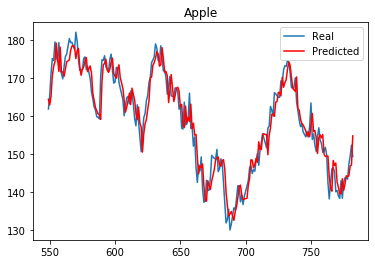

In [25]:
plot_prediction(pred_aapl, "Apple")

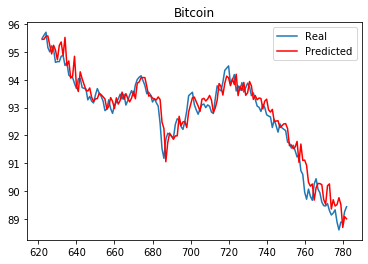

In [26]:
plot_prediction(pred_btc, "Bitcoin")

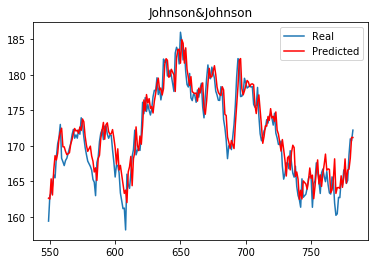

In [27]:
plot_prediction(pred_jnj, "Johnson&Johnson")

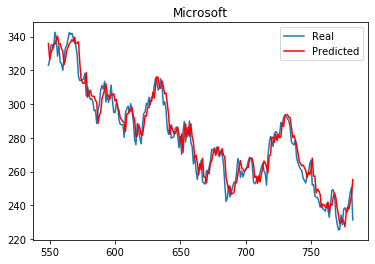

In [28]:
plot_prediction(pred_msft, "Microsoft")

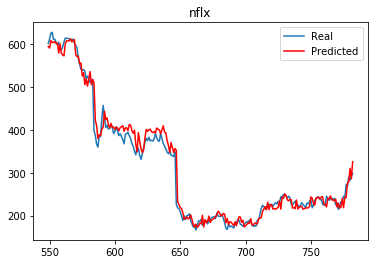

In [29]:
plot_prediction(pred_nflx, "nflx")

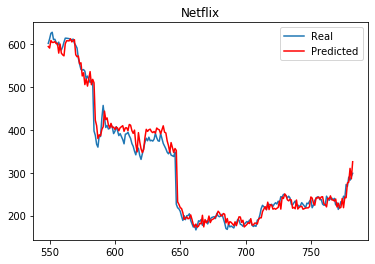

In [30]:
plot_prediction(pred_nflx, "Netflix")

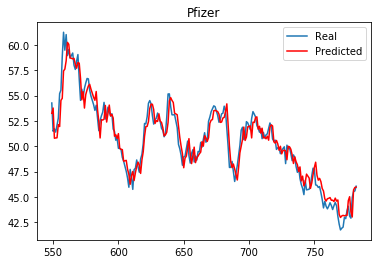

In [31]:
plot_prediction(pred_pfe, "Pfizer")

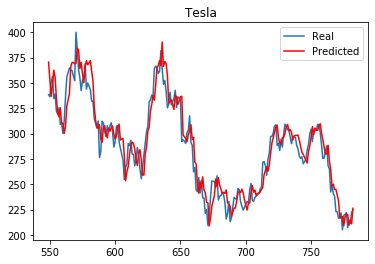

In [33]:
plot_prediction(pred_tsla, "Tesla")